In [1]:
import pandas as pd
import numpy as np

from ckiptagger import WS, POS
from tqdm.notebook import tqdm

In [2]:
df_train = pd.read_csv('news_clustering_train.tsv', sep='\t')
train_titles = {row['index']: row['title'] for _, row in df_train.iterrows()}
train_classes = {row['index']: row['class'] for _, row in df_train.iterrows()}

df_test = pd.read_csv('news_clustering_test.tsv', sep='\t')
test_titles = {row['index']: row['title'] for _, row in df_test.iterrows()}
test_classes = {row['index']: row['class'] for _, row in df_test.iterrows()}

all_news_class = ['體育', '財經', '科技', '旅遊', '農業', '遊戲']

# 斷詞 + POS

In [3]:
# 忽略警告
import warnings
warnings.simplefilter("ignore")
ws, pos = WS('./data/'), POS('./data/')

In [4]:
train_title_cuts = {}
for index, title in tqdm(train_titles.items()):
    word_s = ws([title])
    word_p = pos(word_s)
    train_title_cuts[index] = list(zip(word_s[0], word_p[0]))

In [5]:
test_title_cuts = {}
for index, title in tqdm(test_titles.items()):
    word_s = ws([title])
    word_p = pos(word_s)
    test_title_cuts[index] = list(zip(word_s[0], word_p[0]))

# Bag of Words (BOW)

In [6]:
word2index = {}
index2word = {}
unique_words = list(set(word for pairs in train_title_cuts.values() for word, _ in pairs))

for index, word in enumerate(unique_words):
    word2index[word] = index
    index2word[index] = word

In [7]:
def get_bow_vector_with_selection(pairs, word2index):
    excluded_flags = [
        'Nh', 'Nep', 'Nes', 'DE', 'T', 'P', 'V_2', 'SHI',
        'Dfa', 'Dfb', 'Da', 'Di', 'Dk',
        'Caa', 'Cab', 'Cba', 'Cbb',
        'COLONCATEGORY', 'COMMACATEGORY', 'DASHCATEGORY', 'DOTCATEGORY', 'ETCCATEGORY', 'EXCLAMATIONCATEGORY',
        'PARENTHESISCATEGORY', 'PAUSECATEGORY', 'PERIODCATEGORY', 'QUESTIONCATEGORY', 'SEMICOLONCATEGORY',
        'SPCHANGECATEGORY', 'WHITESPACE'
    ]
    vector = np.zeros(len(word2index))
    for word, flag in pairs:
        if word in word2index and flag not in excluded_flags:
            vector[word2index[word]] += 1
    return vector

In [8]:
train_bow_vectors = {
    index: get_bow_vector_with_selection(pairs, word2index)
    for index, pairs in train_title_cuts.items()
}

test_bow_vectors = {
    index: get_bow_vector_with_selection(pairs, word2index)
    for index, pairs in test_title_cuts.items()
}

# TFIDF

In [9]:
from sklearn.feature_extraction.text import TfidfTransformer

train_index_array, train_vector_array = list(zip(*train_bow_vectors.items()))

# 使用`TfidfTransformer`來將`train_vector_array`轉換成`train_tfidf_vector_array`
tfidfer = TfidfTransformer()
train_tfidf_vector_array = tfidfer.fit_transform(train_vector_array)

display(train_tfidf_vector_array,
        type(train_tfidf_vector_array))

<1800x6690 sparse matrix of type '<class 'numpy.float64'>'
	with 17126 stored elements in Compressed Sparse Row format>

scipy.sparse.csr.csr_matrix

In [10]:
train_tfidf_vectors = {}

for i, index in enumerate(train_index_array):
    vector = train_tfidf_vector_array.getrow(i).toarray()[0]
    train_tfidf_vectors[index] = vector

In [11]:
display(train_tfidf_vectors[120])

array([0., 0., 0., ..., 0., 0., 0.])

In [12]:
test_index_array, test_vector_array = list(zip(*test_bow_vectors.items()))

# 使用同一個`TfidfTransformer`來轉換testing dataset
test_tfidf_vector_array = tfidfer.transform(test_vector_array)

In [13]:
test_tfidf_vectors = {}

for i, index in enumerate(test_index_array):
    vector = test_tfidf_vector_array.getrow(i).toarray()
    test_tfidf_vectors[index] = vector

# TFIDF + Group mean vector: 測試

In [14]:
group_vectors = {news_class: [] for news_class in all_news_class}
group_mean_vector = {}

for index, vector in sorted(train_tfidf_vectors.items()):
    news_class = train_classes[index]
    group_vectors[news_class].append(vector)

for news_class, vectors in group_vectors.items():
    group_mean_vector[news_class] = np.mean(vectors, axis=0)

display(group_mean_vector)

{'體育': array([0.        , 0.00138582, 0.        , ..., 0.00098083, 0.        ,
        0.        ]),
 '財經': array([0.        , 0.        , 0.        , ..., 0.        , 0.00091543,
        0.00203265]),
 '科技': array([0., 0., 0., ..., 0., 0., 0.]),
 '旅遊': array([0., 0., 0., ..., 0., 0., 0.]),
 '農業': array([0.00100089, 0.        , 0.00106131, ..., 0.        , 0.00207037,
        0.        ]),
 '遊戲': array([0.        , 0.        , 0.00109713, ..., 0.        , 0.        ,
        0.0010263 ])}

In [15]:
def cosine_similarity(bow1, bow2):
    uni_dist = lambda x: x/(np.sqrt(np.sum(x**2)))
    return np.sum(uni_dist(bow1) * uni_dist(bow2))

In [16]:
classification = {news_class: [] for news_class in all_news_class}

for index, vector in sorted(test_tfidf_vectors.items()):
    if np.sum(np.square(vector)) == 0:
        continue

    max_val = -2.0
    max_class = None
    
    for news_class, ref_vector in group_mean_vector.items():
        val = cosine_similarity(ref_vector, vector)
        if val > max_val:
            max_class = news_class
            max_val = val

    classification[max_class].append(index)

In [17]:
from collections import Counter

accuracy=[]

for group, ids in classification.items():
    counter = Counter([test_classes[id] for id in ids])
    prediciton=round(counter[group]/sum(counter.values())*100,2)
    accuracy.append(prediciton)
    print(f'{group} : {str(counter):70} \taccuracy : {prediciton}%')

print(f'\nAverage accuracy : {round(np.mean(accuracy),2)}%')

體育 : Counter({'體育': 83, '遊戲': 7, '財經': 6, '旅遊': 6, '農業': 4, '科技': 2})       	accuracy : 76.85%
財經 : Counter({'財經': 75, '科技': 15, '旅遊': 7, '農業': 6, '體育': 4, '遊戲': 2})      	accuracy : 68.81%
科技 : Counter({'科技': 67, '財經': 11, '農業': 6, '體育': 3, '遊戲': 3, '旅遊': 2})      	accuracy : 72.83%
旅遊 : Counter({'旅遊': 78, '農業': 9, '科技': 4, '財經': 3, '遊戲': 1})                	accuracy : 82.11%
農業 : Counter({'農業': 74, '科技': 7, '旅遊': 5, '體育': 4, '財經': 3, '遊戲': 1})       	accuracy : 78.72%
遊戲 : Counter({'遊戲': 86, '體育': 4, '科技': 4, '財經': 2})                         	accuracy : 89.58%

Average accuracy : 78.15%


# Visualization

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='full')
anchor_classes, anchor_vectors = list(zip(*group_mean_vector.items()))

# 為了看清楚Group Mean Vector怎麼幫助我們做分類問題，我們針對Group Mean Vector (anchor) 來進行PCA降維
reduced_anchor_vectors = pca.fit_transform(anchor_vectors)
reduced_test_tfidf_vector_array = pca.transform(test_tfidf_vector_array.toarray())

display(reduced_test_tfidf_vector_array)

array([[-0.0237776 , -0.03045768],
       [ 0.03089514, -0.08325018],
       [-0.02799609, -0.04679851],
       ...,
       [ 0.0402831 , -0.04660735],
       [ 0.09522959, -0.04196424],
       [ 0.03325491, -0.03344588]])

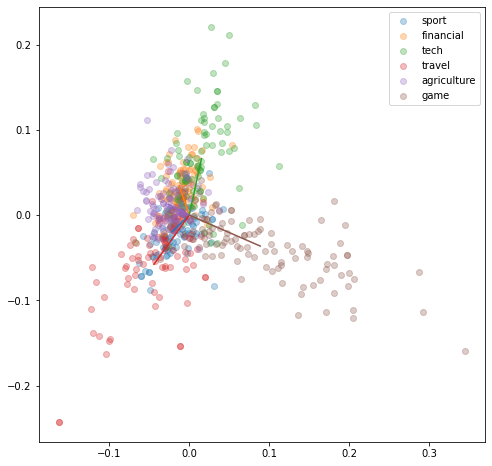

In [19]:
import matplotlib
import matplotlib.pyplot as plt

test_class_array = np.vectorize(test_classes.get)(test_index_array)

label_mapping = {
    '體育': 'sport',
    '財經': 'financial',
    '科技': 'tech',
    '旅遊': 'travel',
    '農業': 'agriculture',
    '遊戲': 'game'
}

plt.figure(figsize=(8, 8))
for real_class in all_news_class:
    plt.scatter(reduced_test_tfidf_vector_array[test_class_array == real_class, 0],
                reduced_test_tfidf_vector_array[test_class_array == real_class, 1],
                label=label_mapping[real_class],
                alpha=0.3)
    i = anchor_classes.index(real_class)
    plt.plot([0, reduced_anchor_vectors[i, 0]], [0, reduced_anchor_vectors[i, 1]])
plt.legend(loc="best", shadow=False, scatterpoints=1)

plt.show()